## Chest X-Ray (Pneumonia): Transfer Learning 

Using Several estandard models trained on Imagenet \
This example uses a VGG19 network + some additional layers \
Only the new added layers are trained, the layers from the original VGG19 network are not trained 

Train accuracy 95.5% \
Val accuracy 95% \
Test accuracy 95.5% \
ROC 98%

(*) Thanks to Juan Carlos Aguilar and Prashantram Sunderaraj for suggestions and detecting an error in previous version

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(421)

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
# We shuffle the original dataset and create val and test more balanced (0,6 train, 0.2 test, 0.2 val)
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------normal
#                  !-------------pneumonia

train_normal = glob.glob("./chest_xray_data/normal/*.jpeg")
train_pneumonia = glob.glob("./chest_xray_data/pneumonia/*.jpeg")
print('there are ',len(train_normal),'normal images and', len(train_pneumonia),'pneumonia images')
COUNT_PNEUMONIA = len(train_pneumonia)
COUNT_NORMAL = len(train_normal)

there are  1583 normal images and 4273 pneumonia images


In [4]:
all_list = [x for x in train_normal]
all_list.extend([x for x in train_pneumonia])

df_all = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                      columns = ['class'])
df_all['image'] = [x for x in all_list]
print(df_all.shape)

(5856, 2)


In [5]:
train_df, dummy_df = train_test_split(df_all, test_size = 0.33, random_state = SEED, 
                                    stratify = df_all['class'])
test_df, val_df = train_test_split(dummy_df, test_size = 0.50, random_state = SEED, 
                                    stratify = dummy_df['class'])

print('train',train_df.shape, 'test', test_df.shape, 'val', val_df.shape)

train (3923, 2) test (966, 2) val (967, 2)


### Data Preparation is performed in the same way as in previous notebooks

In [6]:
# see: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(test_df,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 3923 validated image filenames belonging to 2 classes.
Found 967 validated image filenames belonging to 2 classes.
Found 966 validated image filenames belonging to 2 classes.


In [33]:
# to improve class balancing we calculate the weights to add to the training process

initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

calculated_class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 0.99299
Weight for class 0: 1.85
Weight for class 1: 0.69


## Transfer Learning (adding some layers to previously trained network)

Consists of using a pretrained model as a feature extractor. In this notebook, the selected model is the VGG19 available on the Keras Package 

We include a few layers after removing the 'head'. We only train these new layers.The weights of the original VGG19 network remain the same.

In [8]:
#Setting callbakcs

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 10,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [9]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(    
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [10]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [11]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          class_weight = calculated_class_weight,
          validation_data=ds_val,
          callbacks=[early_stopping_cb,checkpoint_cb]);

Epoch 1/50
123/123 [==============================] - 1171s 10s/step - loss: 0.4900 - binary_accuracy: 0.7716 - val_loss: 0.5746 - val_binary_accuracy: 0.7466
Epoch 2/50
123/123 [==============================] - 1166s 9s/step - loss: 0.3114 - binary_accuracy: 0.8731 - val_loss: 0.4715 - val_binary_accuracy: 0.7859
Epoch 3/50
123/123 [==============================] - 1165s 9s/step - loss: 0.2708 - binary_accuracy: 0.8848 - val_loss: 0.2220 - val_binary_accuracy: 0.9038
Epoch 4/50
123/123 [==============================] - 1164s 9s/step - loss: 0.2495 - binary_accuracy: 0.8980 - val_loss: 0.1756 - val_binary_accuracy: 0.9266
Epoch 5/50
123/123 [==============================] - 1168s 10s/step - loss: 0.2199 - binary_accuracy: 0.9105 - val_loss: 0.1908 - val_binary_accuracy: 0.9224
Epoch 6/50
123/123 [==============================] - 1175s 10s/step - loss: 0.2153 - binary_accuracy: 0.9146 - val_loss: 0.5379 - val_binary_accuracy: 0.7580
Epoch 7/50
123/123 [=============================

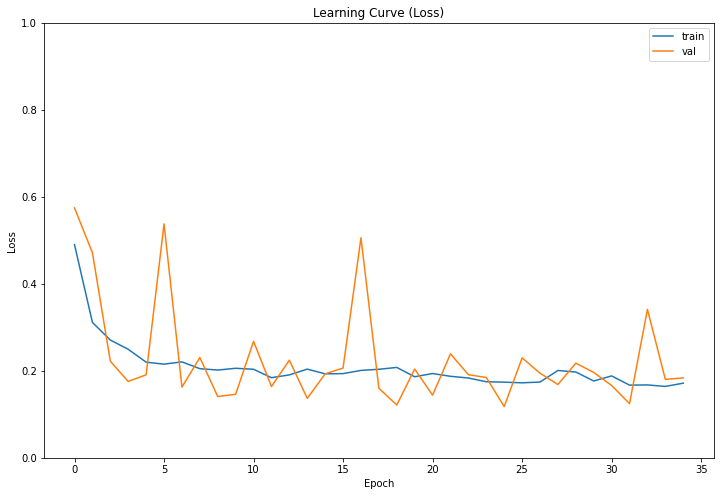

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc='best')
plt.show()

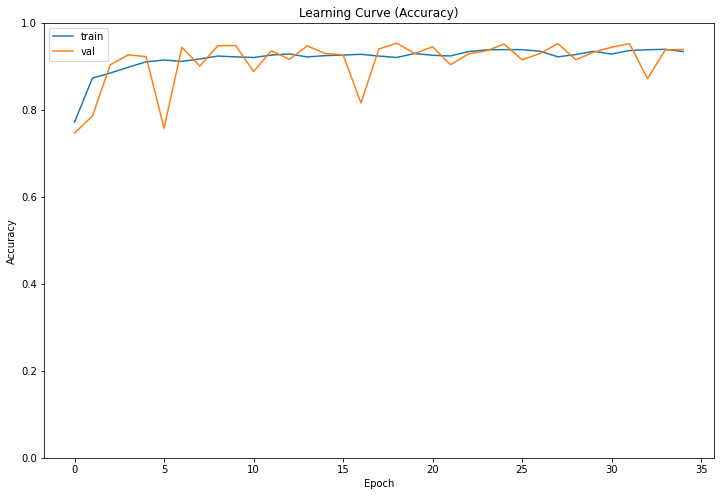

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [14]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.117757149040699
Val accuracy: 0.9513960480690002


In [16]:
score = model_pretrained.evaluate(ds_test, steps = len(test_df), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1231636106967926
Test accuracy: 0.955486536026001


### Result Performance Evaluation</a>  

In [21]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = test_df['class'].copy().map(num_label).astype('int')

In [25]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9554865424430642


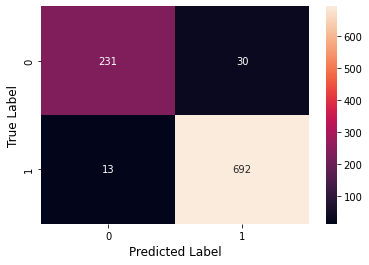

In [26]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [27]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.95      0.89      0.91       261
           1       0.96      0.98      0.97       705

    accuracy                           0.96       966
   macro avg       0.95      0.93      0.94       966
weighted avg       0.96      0.96      0.96       966



ROC_AUC:  0.9858699491861634


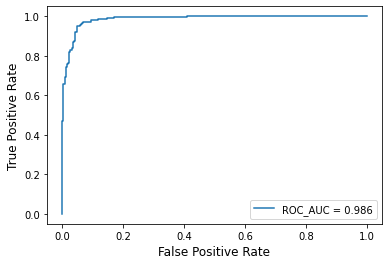

In [28]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

The recall was close to 100%. As we are in the medical field a discussion on the impact of false positives and false negatives is required. The impact on people's health will determine the applicability of a DL approach. Remember. Always Human Supervision!!!

In [29]:
#EOF